In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
file_path = '/content/drive/MyDrive/raw_analyst_ratings.csv'


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from wordcloud import WordCloud
import spacy

# Load CSV from Google Drive
file_path = '/content/drive/MyDrive/raw_analyst_ratings.csv'
df = pd.read_csv(file_path)


In [4]:
df['headline'] = df['headline'].fillna('').str.lower()
df['headline_length'] = df['headline'].apply(len)
print(df['headline_length'].describe())



count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Name: count, dtype: int64


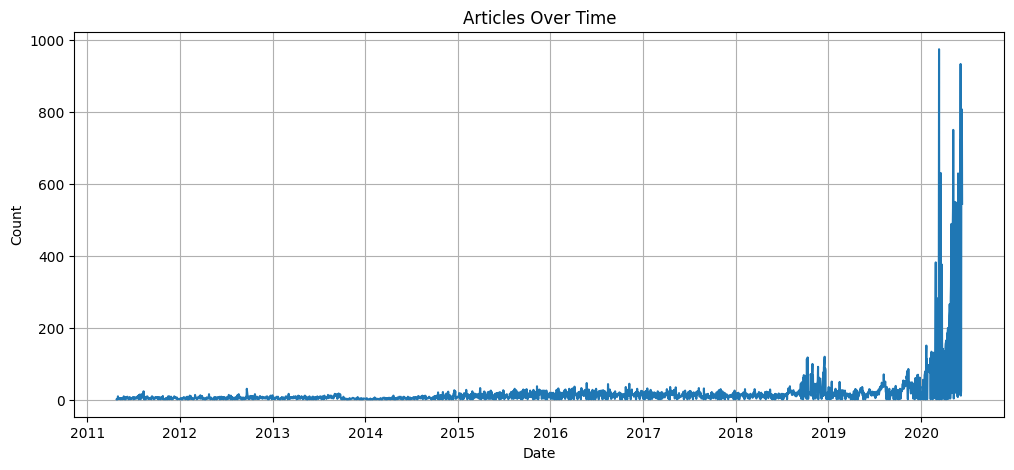

In [5]:
# Convert to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
print(df['publisher'].value_counts().head())

# Date-only and trend
df['date_only'] = df['date'].dt.date
df.groupby('date_only').size().plot(figsize=(12, 5), title='Articles Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.show()


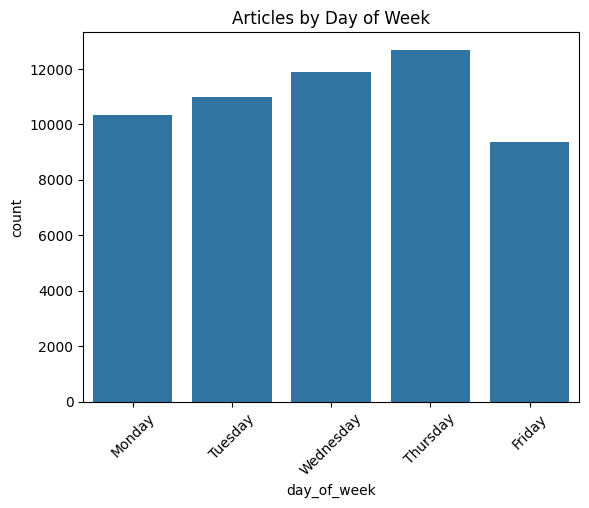

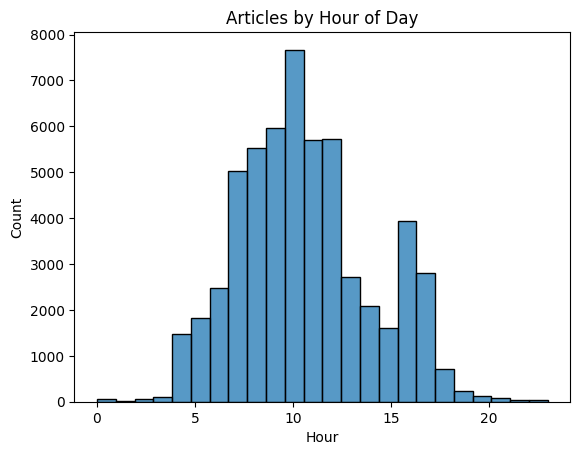

In [6]:
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.day_name()

sns.countplot(data=df, x='day_of_week', order=['Monday','Tuesday','Wednesday','Thursday','Friday'])
plt.title('Articles by Day of Week')
plt.xticks(rotation=45)
plt.show()

sns.histplot(df['hour'], bins=24)
plt.title('Articles by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()


In [7]:
count_vect = CountVectorizer(stop_words='english', max_features=20)
X_count = count_vect.fit_transform(df['headline'])
print("Top Keywords by Count:")
print(pd.DataFrame(X_count.toarray(), columns=count_vect.get_feature_names_out()).sum().sort_values(ascending=False))

tfidf_vect = TfidfVectorizer(stop_words='english', max_features=20)
X_tfidf = tfidf_vect.fit_transform(df['headline'])
print("Top Keywords by TF-IDF:")
print(pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vect.get_feature_names_out()).sum().sort_values(ascending=False))


Top Keywords by Count:
vs            162099
stocks        161776
est           140604
eps           128897
market        120558
shares        114313
reports       108710
update         91723
earnings       87399
sales          79645
benzinga       74516
pt             73068
week           69572
announces      66591
price          64407
buy            64371
mid            62263
downgrades     61959
trading        61182
raises         57802
dtype: int64
Top Keywords by TF-IDF:
stocks        120048.420657
market         83037.704493
shares         77559.971297
earnings       75181.331827
vs             65464.128259
reports        64127.172118
update         63627.866238
benzinga       62142.509181
eps            61187.454960
announces      55964.729030
week           55357.341471
est            53595.025097
pt             50750.846783
downgrades     49541.715976
price          48214.325506
buy            47506.387748
sales          46230.892980
trading        43668.171643
mid            4

In [8]:
lda_vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X_lda = lda_vectorizer.fit_transform(df['headline'])

lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(X_lda)

terms = lda_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"\nTopic #{topic_idx + 1}:")
    print([terms[i] for i in topic.argsort()[-10:][::-1]])



Topic #1:
['pt', 'downgrades', 'buy', 'upgrades', 'raises', 'maintains', 'announces', '00', 'update', 'bank']

Topic #2:
['vs', 'est', 'eps', 'reports', 'sales', 'earnings', 'sees', 'q4', 'q1', 'q2']

Topic #3:
['stocks', 'price', 'target', 'market', 'session', 'moving', 'initiates', '52', 'week', 'coverage']

Topic #4:
['shares', 'market', 'update', 'trading', 'higher', 'says', 'companies', 'lower', 'mid', 'earnings']

Topic #5:
['stocks', 'new', 'benzinga', 'week', 'watch', 'yesterday', 'movers', 'etfs', 'estimate', '10']


In [10]:
# Install spaCy if needed
!pip install -U spacy
!python -m spacy download en_core_web_sm

import spacy
nlp = spacy.load("en_core_web_sm")

sample_text = ' '.join(df['headline'].dropna()[:100].tolist())
doc = nlp(sample_text)

print("Named Entities:")
for ent in doc.ents:
    print(ent.text, "→", ent.label_)


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Named Entities:
52-week → DATE
friday → DATE
52-week → DATE
wednesday → DATE
71 → CARDINAL
friday 46 → DATE
friday → DATE
mid-day → DATE
88 → MONEY
ubs → ORG
87 → MONEY
wells fargo maintains → ORG
95 → MONEY
10 → CARDINAL
friday 30 → DATE
friday → DATE
95 → MONEY
8 → CARDINAL
thursday → DATE
0.71 → MONEY
0.61 → MONEY
1.24b → MONEY
1.21b → MONEY
may 21 → DATE
2020 → DATE
fda → ORG
13f → DATE
13f → DATE
12,626,593 → CARDINAL
bill ackman → PERSON
ubs → ORG
84 → MONEY
fda → ORG
dako omni → ORG
fy20 → CARDINAL
73 → MONE